In [96]:
%matplotlib inline

import os
import time
import math
import json
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from evaluation import load_model_and_metrics, evaluate_on_test_set
from test_visualisation import (
    create_loss_comparison_plot,
    create_improvement_heatmap,
    create_perplexity_comparison
)
from train_with_viz import test_configs_with_tracking, save_model_and_metrics


from new_gpt import ModelConfig, GPTLanguageModel, load_data, get_batch, estimate_loss
from gpt_downsizing import create_custom_config


# detect device
device = torch.device('mps' if torch.mps.is_available() else 'cpu')






seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [97]:
def loss_function(x, minibatch):
    """
    Given parameter x in R^2, compute the average of
    min(13 * ||z||^2, ||z + [9,2]||^2)
    over all w in the minibatch, where z = x - w - 1.
    """
    y = 0.0
    for w in minibatch:
        z = x - w - 1  # z ∈ R^2
        val1 = 13.0 * (z[0]**2 + z[1]**2)
        val2 = (z[0] + 9.0)**2 + (z[1] + 2.0)**2
        y += min(val1, val2)
    return y / len(minibatch)

In [98]:
def gradient_function(x, minibatch):
    """
    Piecewise gradient of the loss_function with respect to x.
    If 13*||z||^2 < ||z + [9,2]||^2, use gradient of 13*||z||^2,
    else use gradient of ||z + [9,2]||^2.  Averaged over minibatch.
    """
    grad = np.zeros_like(x)
    for w in minibatch:
        z = x - w - 1
        val1 = 13.0 * (z[0]**2 + z[1]**2)
        val2 = (z[0] + 9.0)**2 + (z[1] + 2.0)**2

        if val1 < val2:
            # ∇(13||z||^2) = 26 z
            grad[0] += 26.0 * z[0]
            grad[1] += 26.0 * z[1]
        else:
            # ∇||z + [9,2]||^2 = 2*(z + [9,2])
            grad[0] += 2.0 * (z[0] + 9.0)
            grad[1] += 2.0 * (z[1] + 2.0)

    return grad / len(minibatch)

In [99]:
def sgd_optimizer(
    data,
    x_init,
    loss_fn,
    grad_fn,
    method='constant',
    alpha=0.01,
    batch_size=8,
    max_epochs=100,
    beta1=0.9,         # for Heavy Ball and Adam
    beta2=0.999,       # for RMSProp and Adam
    epsilon=1e-8,      # for RMSProp and Adam
    polyak_f_star=0.0  # for Polyak steps
):
    """
    Perform mini-batch SGD on the given data using various step-size methods.

    :param data: array of shape (n, 2) representing n training points in R^2.
    :param x_init: initial parameter vector in R^2.
    :param loss_fn: f(x, minibatch) -> scalar.
    :param grad_fn: grad_f(x, minibatch) -> R^2 gradient.
    :param method: one of 'constant', 'polyak', 'rmsprop', 'heavy_ball', 'adam'.
    :param alpha: base step size (learning rate).
    :param batch_size: size of each mini-batch.
    :param max_epochs: number of passes through the data.
    :param beta1: momentum parameter (heavy ball, Adam).
    :param beta2: second-moment decay (RMSProp, Adam).
    :param epsilon: small constant to avoid division by zero.
    :param polyak_f_star: known (or estimated) minimal value of f.
    :return: (x, losses) final parameters and list of losses per epoch.
    """
    n = data.shape[0]
    x = x_init.copy()
    losses = []
    m = np.zeros_like(x)  # momentum / first moment
    v = np.zeros_like(x)  # second moment (for RMSProp/Adam)
    iteration = 0

    for epoch in range(max_epochs):
        # Shuffle data each epoch
        indices = np.random.permutation(n)
        data_shuffled = data[indices]

        # Mini-batch loop
        for start_idx in range(0, n, batch_size):
            minibatch = data_shuffled[start_idx:start_idx + batch_size]
            grad = grad_fn(x, minibatch)

            if method == 'constant':
                x -= alpha * grad

            elif method == 'polyak':
                current_loss = loss_fn(x, minibatch)
                denom = np.dot(grad, grad) + 1e-20
                alpha_k = (current_loss - polyak_f_star) / denom
                if alpha_k < 0:
                    alpha_k = alpha
                x -= alpha_k * grad

            elif method == 'rmsprop':
                v = beta2 * v + (1 - beta2) * (grad * grad)
                x -= alpha * grad / (np.sqrt(v) + epsilon)

            elif method == 'heavy_ball':
                m = beta1 * m + alpha * grad
                x -= m

            elif method == 'adam':
                iteration += 1
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * (grad * grad)
                m_hat = m / (1 - beta1**iteration)
                v_hat = v / (1 - beta2**iteration)
                x -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        # Record full-dataset loss at end of epoch
        epoch_loss = loss_fn(x, data)
        losses.append(epoch_loss)

    return x, losses

In [100]:
def train_sgd(model, dataloader, loss_fn,
              num_epochs=20,
              step_method='constant',
              alpha=1e-2,
              f_star=0.0):
    """
    Mini-batch SGD training loop supporting:
      - constant step size (step_method='constant')
      - Polyak adaptive step size (step_method='polyak')
    """
    model.to(device).train()
    history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for Xb, yb in dataloader:
            Xb, yb = Xb.to(device), yb.to(device)
            # forward
            out = model(Xb)
            loss = loss_fn(out, yb)
            # backward
            model.zero_grad()
            loss.backward()
            # gather all gradients into one vector
            grads = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
            if step_method == 'constant':
                lr = alpha
            else:  # 'polyak'
                loss_val = loss.item()
                denom = grads.dot(grads).item() + 1e-12
                lr = max((loss_val - f_star) / denom, alpha)
            # manual parameter update
            with torch.no_grad():
                for p in model.parameters():
                    if p.grad is not None:
                        p.data -= lr * p.grad
            running_loss += loss.item() * Xb.size(0)
        history.append(running_loss / len(dataloader.dataset))
    return history

In [101]:
# simple logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [102]:

# generate toy binary classification data
np.random.seed(0)
N = 1000
X = np.random.randn(N, 2)
w_true = np.array([2.0, -3.0])
b_true = 0.5
logits = X.dot(w_true) + b_true
probs = 1/(1+np.exp(-logits))
y = (probs > 0.5).astype(np.float32)

# wrap in DataLoader
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
ds = TensorDataset(X_t, y_t)
loader = DataLoader(ds, batch_size=32, shuffle=True)


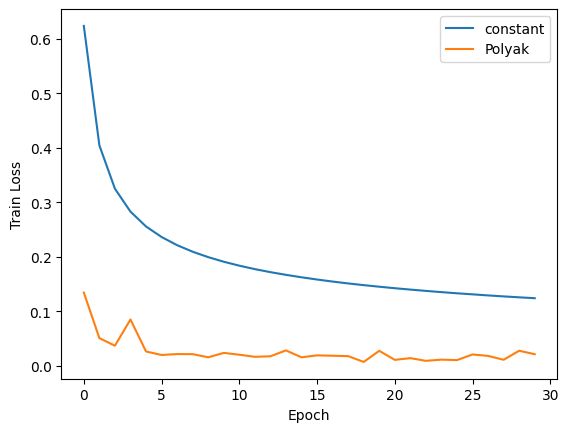

In [103]:
bce = nn.BCELoss()

# constant-LR run
model_const = LogisticRegression(2)
hist_const = train_sgd(model_const, loader, bce,
                       num_epochs=30,
                       step_method='constant',
                       alpha=0.1)

# Polyak run
model_poly = LogisticRegression(2)
hist_poly  = train_sgd(model_poly, loader, bce,
                       num_epochs=30,
                       step_method='polyak',
                       alpha=0.1,
                       f_star=0.0)

# plot training loss curves
plt.plot(hist_const, label='constant')
plt.plot(hist_poly,  label='Polyak')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend();


In [104]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


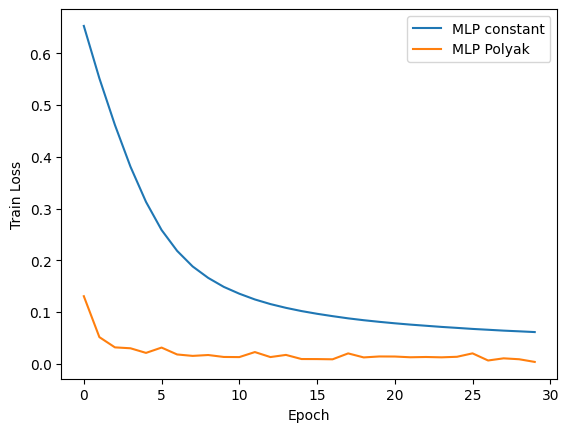

In [105]:

# constant-LR
mlp_const = SimpleMLP(2)
h1 = train_sgd(mlp_const, loader, bce,
               num_epochs=30,
               step_method='constant',
               alpha=0.05)

# Polyak
mlp_poly  = SimpleMLP(2)
h2 = train_sgd(mlp_poly, loader, bce,
               num_epochs=30,
               step_method='polyak',
               alpha=0.05,
               f_star=0.0)

plt.figure()
plt.plot(h1, label='MLP constant')
plt.plot(h2, label='MLP Polyak')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend();


In [106]:

# simple linear model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 1)

    def forward(self, x):
        return self.lin(x)

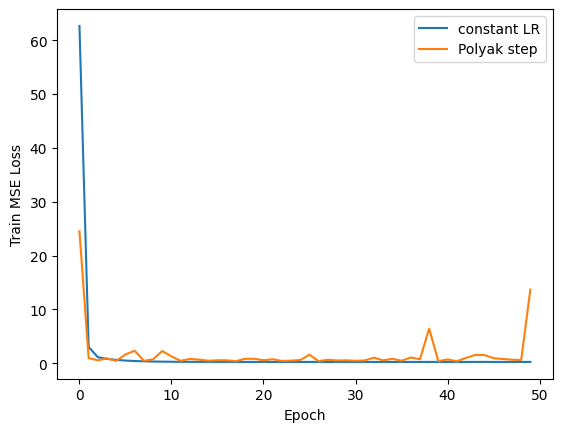

Final constant LR loss: 0.2319
Final Polyak loss:        13.6639


In [107]:
'''
1a
'''
# generate synthetic linear data y = 4x - 2 + noise
torch.manual_seed(0)
N = 200
X = torch.linspace(-5, 5, N).unsqueeze(1)
y = 4 * X - 2 + 0.5 * torch.randn_like(X)

# wrap in DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)





mse = nn.MSELoss(reduction='mean')

# train with constant LR
model_const = LinearModel().to(device)
hist_const = train_sgd(model_const, loader, mse,
                       num_epochs=50,
                       step_method='constant',
                       alpha=1e-2,
                       f_star=0.0)

# train with Polyak step
model_poly = LinearModel().to(device)
hist_poly = train_sgd(model_poly, loader, mse,
                      num_epochs=50,
                      step_method='polyak',
                      alpha=1e-4,  # lower bound for lr
                      f_star=0.0)

# plot losses
plt.figure()
plt.plot(hist_const, label='constant LR')
plt.plot(hist_poly, label='Polyak step')
plt.xlabel('Epoch')
plt.ylabel('Train MSE Loss')
plt.legend()
plt.show()

# print final loss values
print(f"Final constant LR loss: {hist_const[-1]:.4f}")
print(f"Final Polyak loss:        {hist_poly[-1]:.4f}")


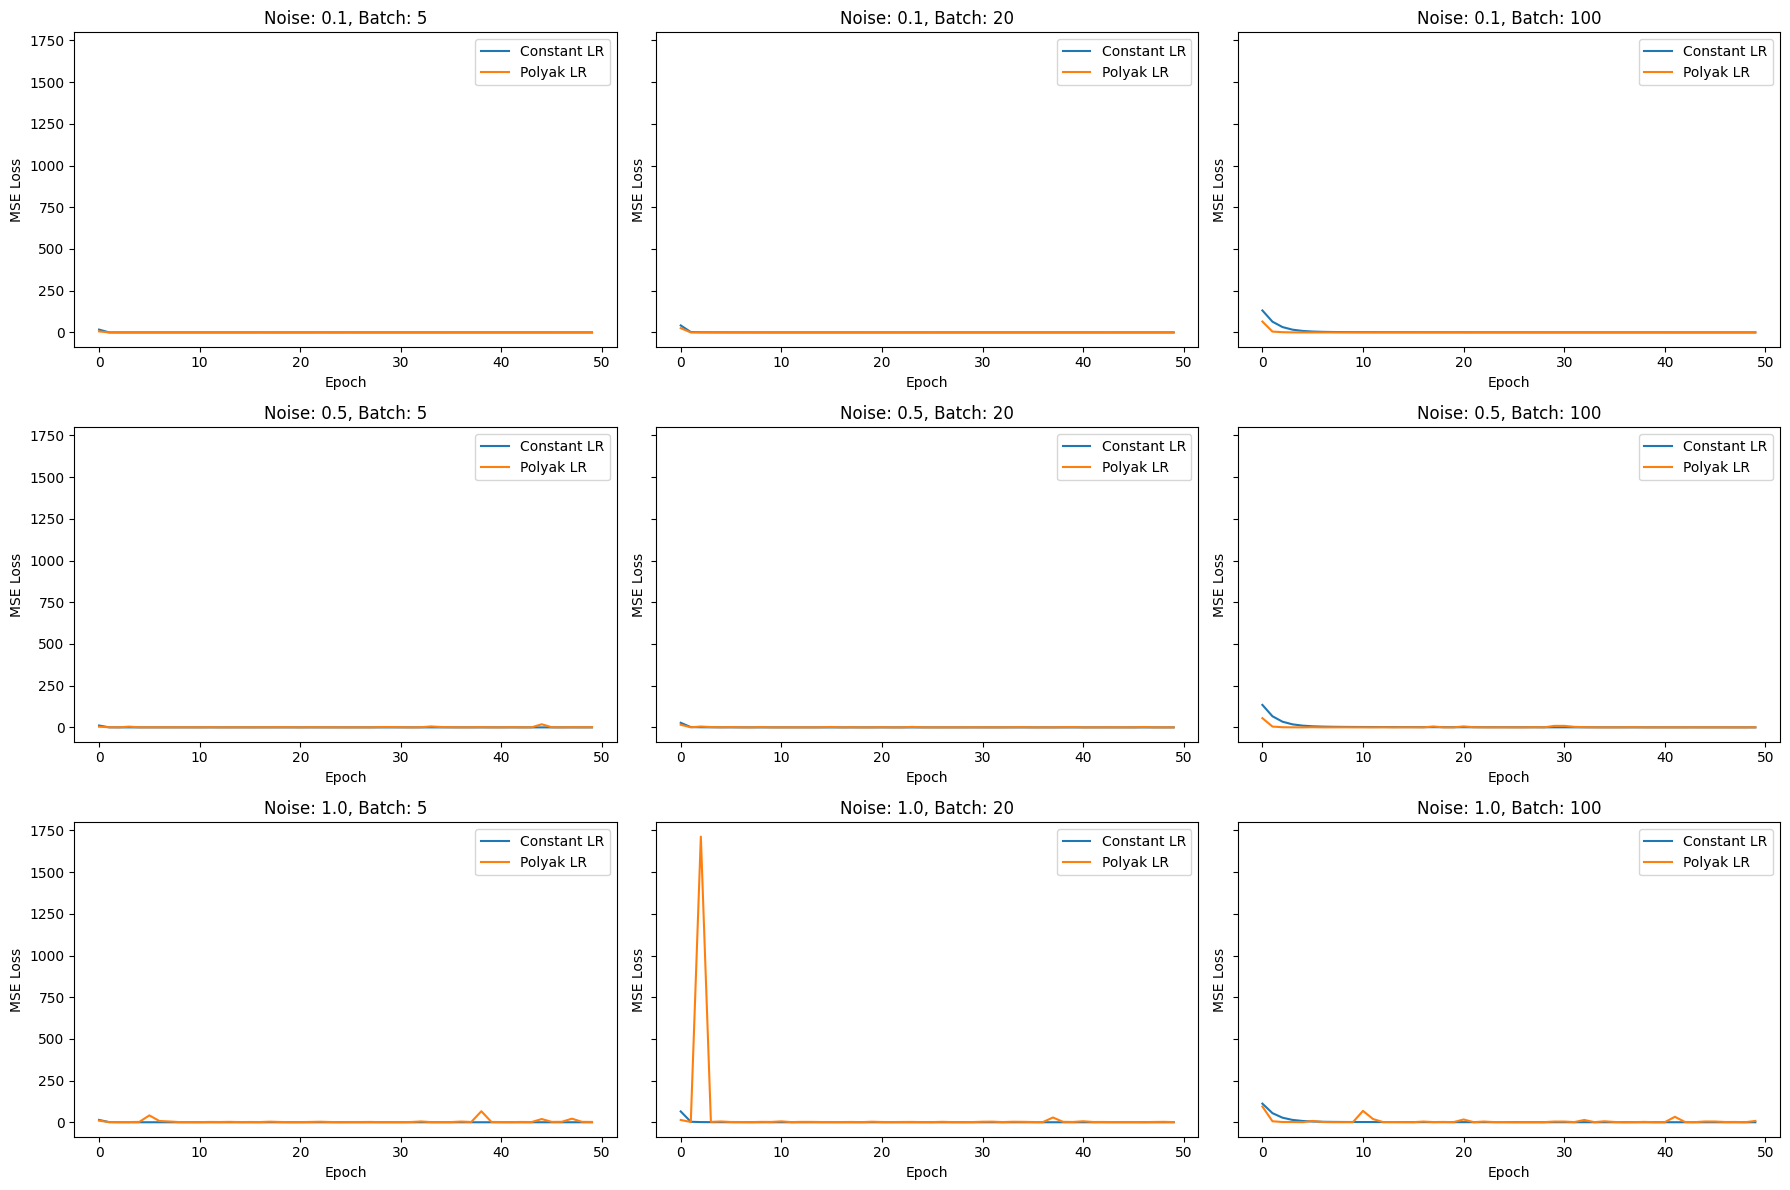

In [108]:
'''
1b
'''
# 1(b) - Investigate different batch sizes and noise levels

torch.manual_seed(0)
np.random.seed(0)

batch_sizes = [5, 20, 100]  # small, medium, large mini-batches
noise_levels = [0.1, 0.5, 1.0]  # low, medium, high noise

results = {}

for noise_std in noise_levels:
    for batch_size in batch_sizes:
        # Generate new noisy data each time
        X = torch.linspace(-5, 5, 200).unsqueeze(1)
        y = 4 * X - 2 + noise_std * torch.randn_like(X)

        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Constant step size model
        model_const = LinearModel().to(device)
        hist_const = train_sgd(model_const, loader, mse,
                               num_epochs=50,
                               step_method='constant',
                               alpha=1e-2)

        # Polyak step size model
        model_poly = LinearModel().to(device)
        hist_poly = train_sgd(model_poly, loader, mse,
                              num_epochs=50,
                              step_method='polyak',
                              alpha=1e-4,
                              f_star=0.0)

        # Save results
        key = f"noise_{noise_std}_batch_{batch_size}"
        results[key] = {
            'constant': hist_const,
            'polyak': hist_poly
        }

# Now plot all results
fig, axes = plt.subplots(len(noise_levels), len(batch_sizes), figsize=(18, 12), sharey=True)

for i, noise_std in enumerate(noise_levels):
    for j, batch_size in enumerate(batch_sizes):
        ax = axes[i, j]
        key = f"noise_{noise_std}_batch_{batch_size}"
        ax.plot(results[key]['constant'], label='Constant LR')
        ax.plot(results[key]['polyak'], label='Polyak LR')
        ax.set_title(f"Noise: {noise_std}, Batch: {batch_size}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE Loss')
        ax.legend()

plt.tight_layout()
plt.show()


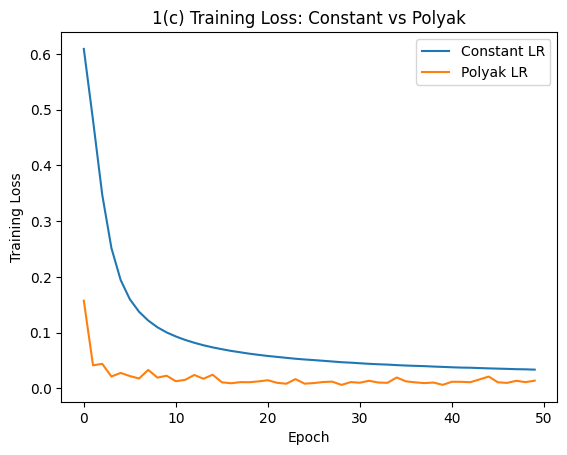

Constant LR Test Accuracy: 0.9900
Polyak LR   Test Accuracy: 1.0000


In [109]:
# 1(c) Compare SGD with constant step size vs Polyak’s step size
# on the week-6 binary classification task

# (Re)generate the synthetic binary classification data
torch.manual_seed(0)
np.random.seed(0)
N = 1000
X = np.random.randn(N, 2)
w_true = np.array([2.0, -3.0])
b_true = 0.5
logits = X.dot(w_true) + b_true
probs = 1 / (1 + np.exp(-logits))
y = (probs > 0.5).astype(np.float32)

# Split into train/test
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_t, y_t)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Initialize two MLPs
model_const = SimpleMLP(2).to(device)
model_poly = SimpleMLP(2).to(device)

# Train with constant LR
hist_const = train_sgd(
    model_const,
    train_loader,
    bce,
    num_epochs=50,
    step_method='constant',
    alpha=0.1
)

# Train with Polyak step size
hist_poly = train_sgd(
    model_poly,
    train_loader,
    bce,
    num_epochs=50,
    step_method='polyak',
    alpha=0.01,  # lower-bound on the step
    f_star=0.0
)

# Plot training loss curves
plt.figure()
plt.plot(hist_const, label='Constant LR')
plt.plot(hist_poly, label='Polyak LR')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('1(c) Training Loss: Constant vs Polyak')
plt.legend()
plt.show()


# Evaluate on the held-out test set
def compute_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = (model(Xb) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


acc_const = compute_accuracy(model_const, test_loader)
acc_poly = compute_accuracy(model_poly, test_loader)

print(f"Constant LR Test Accuracy: {acc_const:.4f}")
print(f"Polyak LR   Test Accuracy: {acc_poly:.4f}")


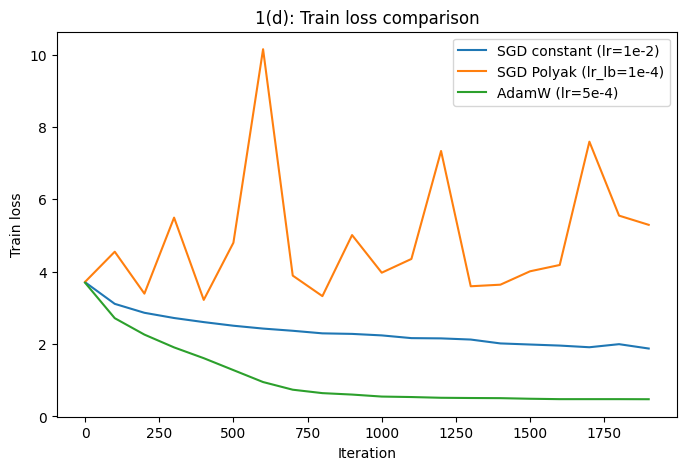

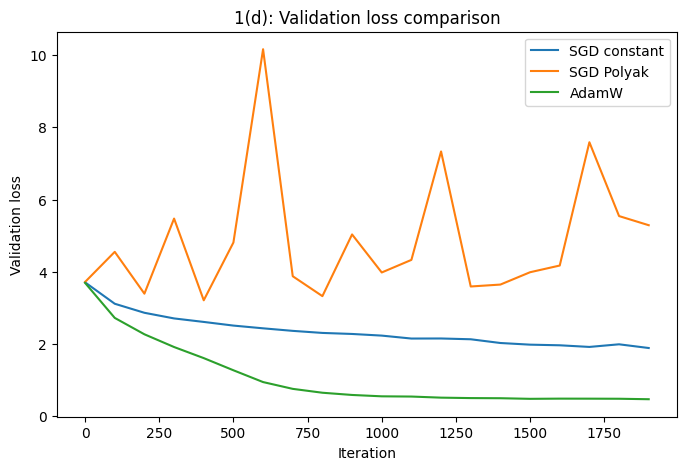

In [111]:
# 1. Prepare config and data
config = create_custom_config()
train_data, val_data, encode, decode, vocab_size = load_data(config)

# 2. Training settings
num_iters = 2000
eval_interval = 100
polyak_f_star = 0.0


# 3. Helper to do one full training run
def train_transformer(method, lr, betas=None):
    model = GPTLanguageModel(config, vocab_size).to(config.device)
    if method == 'constant':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif method == 'adam':
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=betas or (0.9, 0.999))
    # for Polyak we'll do manual updates
    train_losses, val_losses = [], []

    for it in range(num_iters):
        # evaluate periodically
        if it % eval_interval == 0:
            losses = estimate_loss(model, config, train_data, val_data)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

        # get batch
        xb, yb = get_batch(config, 'train', train_data, val_data)
        logits, loss = model(xb, yb)
        model.zero_grad()
        loss.backward()

        if method == 'polyak':
            # compute gradient norm²
            grads = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
            denom = grads.dot(grads).item() + 1e-12
            current_loss = loss.item()
            alpha_k = max((current_loss - polyak_f_star) / denom, lr)
            with torch.no_grad():
                for p in model.parameters():
                    if p.grad is not None:
                        p.data -= alpha_k * p.grad
        else:
            optimizer.step()

    return train_losses, val_losses


# 4. Run all three methods with tuned hyper-params
hist_const = train_transformer('constant', lr=1e-2)
hist_poly = train_transformer('polyak', lr=1e-4)
hist_adam = train_transformer('adam', lr=5e-4, betas=(0.9, 0.98))

# 5. Plot comparison
steps = list(range(0, num_iters, eval_interval))
plt.figure(figsize=(8, 5))
plt.plot(steps, hist_const[0], label='SGD constant (lr=1e-2)')
plt.plot(steps, hist_poly[0], label='SGD Polyak (lr_lb=1e-4)')
plt.plot(steps, hist_adam[0], label='AdamW (lr=5e-4)')
plt.xlabel('Iteration')
plt.ylabel('Train loss')
plt.title('1(d): Train loss comparison')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(steps, hist_const[1], label='SGD constant')
plt.plot(steps, hist_poly[1], label='SGD Polyak')
plt.plot(steps, hist_adam[1], label='AdamW')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')
plt.title('1(d): Validation loss comparison')
plt.legend()
plt.show()


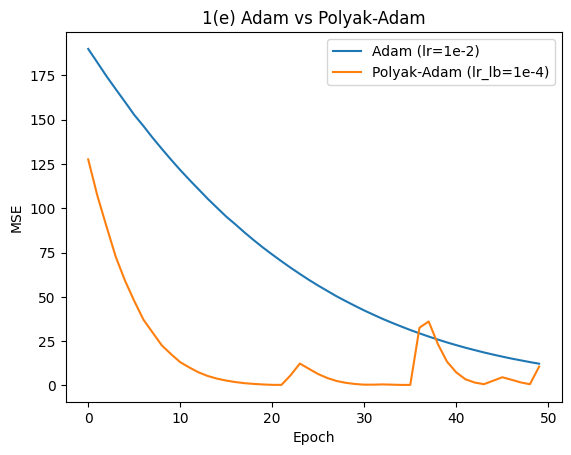

Final Adam loss       : 12.2880
Final Polyak-Adam loss: 10.6303


In [116]:
''' 1(e) – Polyak-Adam vs Adam on noisy linear regression '''
import torch, numpy as np, matplotlib.pyplot as plt

torch.manual_seed(0);
np.random.seed(0)

# ----- synthetic data -----
N = 200
X = torch.linspace(-5, 5, N).unsqueeze(1)
y = 4 * X - 2 + 0.5 * torch.randn_like(X)

loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X, y),
    batch_size=20, shuffle=True)

mse = torch.nn.MSELoss()


# ----- helper: Polyak-Adam -----
def train_polyak_adam(model, dataloader, loss_fn,
                      num_epochs=50,
                      beta1=0.9, beta2=0.999, eps=1e-8,
                      lr_lb=1e-4, f_star=0.0, device='cpu'):
    model.to(device).train()
    m, v = [torch.zeros_like(p, device=device) for p in model.parameters()], \
        [torch.zeros_like(p, device=device) for p in model.parameters()]
    step, history = 0, []
    for epoch in range(num_epochs):
        running = 0.0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            step += 1
            # forward / backward
            pred = model(xb)
            loss = loss_fn(pred, yb)
            model.zero_grad()
            loss.backward()

            # grad norm² for Polyak step
            grads = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
            gnorm2 = grads.dot(grads) + 1e-20
            alpha_k = max((loss.item() - f_star) / gnorm2.item(), lr_lb)

            # Adam moments and update
            with torch.no_grad():
                for i, p in enumerate(model.parameters()):
                    if p.grad is None: continue
                    m[i] = beta1 * m[i] + (1 - beta1) * p.grad
                    v[i] = beta2 * v[i] + (1 - beta2) * (p.grad * p.grad)
                    m_hat = m[i] / (1 - beta1 ** step)
                    v_hat = v[i] / (1 - beta2 ** step)
                    p -= alpha_k * m_hat / (v_hat.sqrt() + eps)

            running += loss.item() * xb.size(0)
        history.append(running / len(dataloader.dataset))
    return history


# ----- model definition -----
class LinearModel(torch.nn.Module):
    def __init__(self): super().__init__(); self.lin = torch.nn.Linear(1, 1)

    def forward(self, x): return self.lin(x)


device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# ----- Adam baseline -----
model_adam = LinearModel().to(device)
opt = torch.optim.Adam(model_adam.parameters(), lr=1e-2)
hist_adam = []
for epoch in range(50):
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model_adam(xb)
        loss = mse(pred, yb)
        opt.zero_grad();
        loss.backward();
        opt.step()
        running += loss.item() * xb.size(0)
    hist_adam.append(running / len(loader.dataset))

# ----- Polyak-Adam -----
model_padam = LinearModel()
hist_padam = train_polyak_adam(model_padam, loader, mse,
                               num_epochs=50, lr_lb=1e-4, device=device)

# ----- plot -----
plt.figure()
plt.plot(hist_adam, label='Adam (lr=1e-2)')
plt.plot(hist_padam, label='Polyak-Adam (lr_lb=1e-4)')
plt.xlabel('Epoch');
plt.ylabel('MSE');
plt.title('1(e) Adam vs Polyak-Adam')
plt.legend();
plt.show()

print(f'Final Adam loss       : {hist_adam[-1]:.4f}')
print(f'Final Polyak-Adam loss: {hist_padam[-1]:.4f}')
